In [12]:
import polars as pl
import numpy as np
import scipy.stats as stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

def compute_silhuette(X,labels):
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)


    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])

    y_lower = 10
    for i in range(n_clusters_):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
                sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters_)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.show()

In [3]:
history_train.head(2)

user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
u32,list[datetime[μs]],list[f32],list[i32],list[f32]
13538,"[2023-04-27 10:17:43, 2023-04-27 10:18:01, … 2023-05-17 20:36:34]","[100.0, 35.0, … 100.0]","[9738663, 9738569, … 9769366]","[17.0, 12.0, … 16.0]"
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]"


In [4]:
articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""


In [5]:
%%time

from rich.progress import Progress


def get_single_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name))[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique())[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_exploded_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique()).explode(f_name)[f_name].to_list()
        return feature_values
    return get_feature


# ner_clusters for the moment is not used since there are too much unique values (more than 44k)
columns = ['category', 'article_type', 'sentiment_label', 'sentiment_score']
return_dtypes = [pl.Int64, pl.String, pl.String, pl.Float64]
with Progress() as progress: 
    
    tasks = {}
    for col in columns:
        tasks[col] = progress.add_task(f"Getting {col}", total=history_train.shape[0])
    tasks['entity_groups'] = progress.add_task("Getting entity_groups", total=history_train.shape[0])
    tasks['entity_groups_detailed'] = progress.add_task("Getting detailed entity_groups", total=history_train.shape[0])
    tasks['topics'] = progress.add_task("Getting topics", total=history_train.shape[0])

    history_train = history_train.with_columns(
        [pl.col('article_id_fixed').map_elements(get_single_feature_function(col, tasks[col]), 
                                                 return_dtype=pl.List(dtype)).alias(col)
         for col, dtype in zip(columns, return_dtypes)] + \
        [pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('entity_groups', tasks['entity_groups']), 
                                                 return_dtype=pl.List(pl.String)).alias('entity_groups'),
         pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('topics', tasks['topics']), 
                                                 return_dtype=pl.List(pl.String)).alias('topics_flatten'),
         pl.col('article_id_fixed').map_elements(get_unique_list_feature_function('entity_groups', tasks['entity_groups_detailed']), 
                                                 return_dtype=pl.List(pl.List(pl.String))).alias('entity_groups_detailed')]
    )
    
history_train.head(2)

Output()

CPU times: user 4min 26s, sys: 21.1 s, total: 4min 47s
Wall time: 3min 7s


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed,category,article_type,sentiment_label,sentiment_score,entity_groups,topics_flatten,entity_groups_detailed
u32,list[datetime[μs]],list[f32],list[i32],list[f32],list[i64],list[str],list[str],list[f64],list[str],list[str],list[list[str]]
13538,"[2023-04-27 10:17:43, 2023-04-27 10:18:01, … 2023-05-17 20:36:34]","[100.0, 35.0, … 100.0]","[9738663, 9738569, … 9769366]","[17.0, 12.0, … 16.0]","[565, 572, … 140]","[""article_default"", ""article_fullscreen_gallery"", … ""article_default""]","[""Neutral"", ""Neutral"", … ""Negative""]","[0.8108, 0.7985, … 0.9959]","[null, null, … ""ORG""]","[""Livsstil"", ""Erotik"", … ""Uddannelse""]","[[], [], … [""ORG"", ""PER"", ""LOC""]]"
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]","[457, 457, … 118]","[""article_default"", ""article_default"", … ""article_default""]","[""Negative"", ""Neutral"", … ""Neutral""]","[0.9712, 0.9115, … 0.8372]","[null, ""PER"", … ""PER""]","[""Livsstil"", ""Samfund"", … ""Dyr""]","[[], [""PER"", ""ORG""], … [""PER"", ""ORG""]]"


In [6]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

def sentiment_score_strong_pct(labels, scores, label_name, threshold=0.8):
    scores_filter = np.array(labels) == label_name
    label_scores = np.array(scores)[scores_filter]
    return np.sum(label_scores > threshold) / len(labels) if len(label_scores) > 0 else 0

history_t= history_train.with_columns(
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Negative')
    ).alias('PctStrongNegative'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Neutral')
    ).alias('PctStrongNeutral'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Positive')
    ).alias('PctStrongPositive')
).with_columns(
    pl.col('read_time_fixed').list.len().alias('NumArticlesHistory'),
    pl.col('read_time_fixed').list.median().alias('MedianReadTime'),
    pl.col('read_time_fixed').list.max().alias('MaxReadTime'),
    pl.col('read_time_fixed').list.sum().alias('TotalReadTime'),
    pl.col('scroll_percentage_fixed').list.median().alias('MedianScrollPercentage'),
    pl.col('scroll_percentage_fixed').list.max().alias('MaxScrollPercentage'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.weekday()).alias('weekdays'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.hour()).alias('hours'),
).with_columns(
    pl.col('weekdays').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentWeekday'),
    pl.col('hours').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentHour'),
    pl.col('category').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int16).alias('MostFrequentCategory'),
    (1 - (pl.col('article_type').list.count_matches('article_default') / pl.col('NumArticlesHistory'))).alias('PctNotDefaultArticles'),
    (pl.col('sentiment_label').list.count_matches('Negative') / pl.col('NumArticlesHistory')).alias('NegativePct'),
    (pl.col('sentiment_label').list.count_matches('Positive') / pl.col('NumArticlesHistory')).alias('PositivePct'),
    (pl.col('sentiment_label').list.count_matches('Neutral') / pl.col('NumArticlesHistory')).alias('NeutralPct'),
).drop(
    ['read_time_fixed', 'scroll_percentage_fixed', 'impression_time_fixed', 
     'weekdays', 'hours', 'sentiment_label', 'sentiment_score', 'article_type']
#).with_columns(
#    (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
#    for entity in unique_entities
).drop('entity_groups')

history_t.head(2)


user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64
13538,"[9738663, 9738569, … 9769366]","[565, 572, … 140]","[""Livsstil"", ""Erotik"", … ""Uddannelse""]","[[], [], … [""ORG"", ""PER"", ""LOC""]]",0.54792,0.115732,0.070524,582,6.0,672.0,7192.0,32.0,100.0,3,3,118,0.073883,0.601375,0.12543,0.223368
14241,"[9738557, 9738528, … 9767852]","[457, 457, … 118]","[""Livsstil"", ""Samfund"", … ""Dyr""]","[[], [""PER"", ""ORG""], … [""PER"", ""ORG""]]",0.541401,0.146497,0.057325,179,19.0,1574.0,7754.0,100.0,100.0,3,13,118,0.139665,0.553073,0.094972,0.22905


In [7]:
unique_category = articles.select('category')['category'].unique().to_list()
unique_category = [e for e in unique_category if e is not None]
unique_category

#history_t = history_t.with_columns(
#    (pl.col('category').list.count_matches(entity) / pl.col('category').list.len()).alias(f'{entity}Pct')
#    for entity in unique_category
#    ).drop(['category','user_id','article_id_fixed','topics_flatten','entity_groups_detailed'])
#history_t.head(2)


[2,
 22,
 68,
 118,
 140,
 142,
 414,
 457,
 498,
 512,
 529,
 539,
 561,
 565,
 572,
 731,
 806,
 1505,
 2077,
 2341,
 2504,
 2731,
 2737,
 2889,
 2975]

In [8]:
emb = history_t.drop(['category','user_id','article_id_fixed','topics_flatten','entity_groups_detailed']).to_pandas().dropna()
#emb = emb.drop(labels = '2737Pct', axis = 1)
n_emb=(emb-emb.min())/(emb.max()-emb.min())
n_emb = emb.to_numpy()

# TSNE Embedding

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(n_emb)

In [25]:
import plotly.express as px
import numpy as np

x, y, z = np.transpose(tsne_embedding)

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

# DBSCAN Clustering

In [ ]:
X = StandardScaler().fit_transform(tsne_embedding)
db = DBSCAN(eps=0.26,min_samples=80).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
noisy_points = db.labels_==-1
cluster_points = ~noisy_points
print("Number of clusters = %d"%n_clusters_)
print("Number of cluster points = %d"%sum(cluster_points))
print("Number of noisy points = %d"%sum(noisy_points))
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique,counts)
plt.show()

In [ ]:
compute_silhuette(X,labels)

# Gaussian Mixture

Number of clusters = 2
Number of cluster points = 15141
Number of noisy points = 0


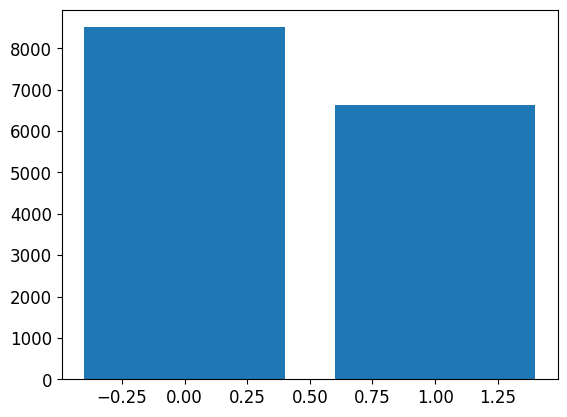

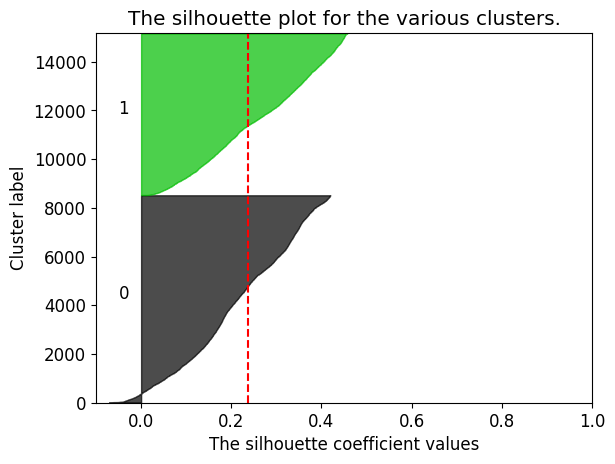

Number of clusters = 3
Number of cluster points = 15141
Number of noisy points = 0


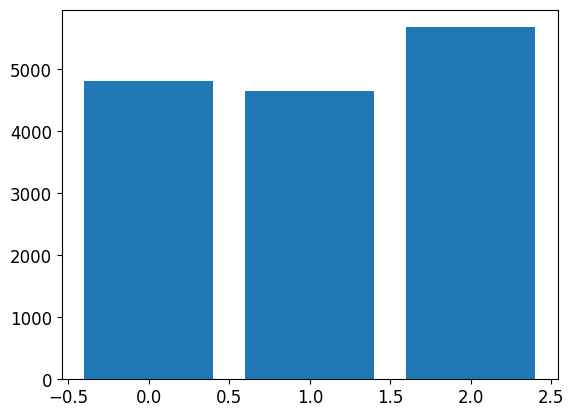

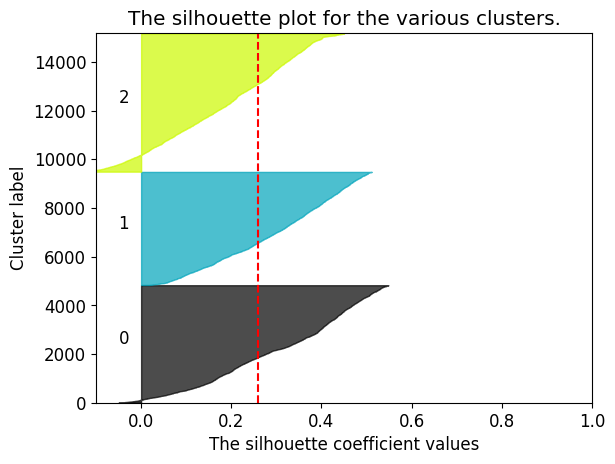

Number of clusters = 4
Number of cluster points = 15141
Number of noisy points = 0


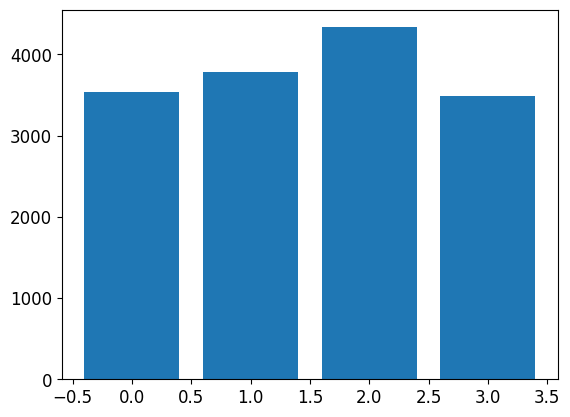

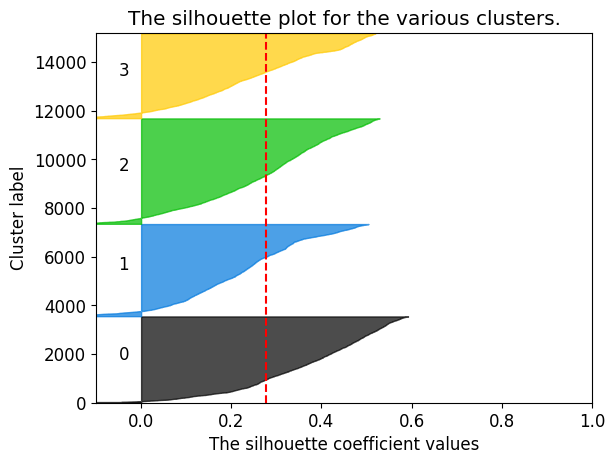

Number of clusters = 5
Number of cluster points = 15141
Number of noisy points = 0


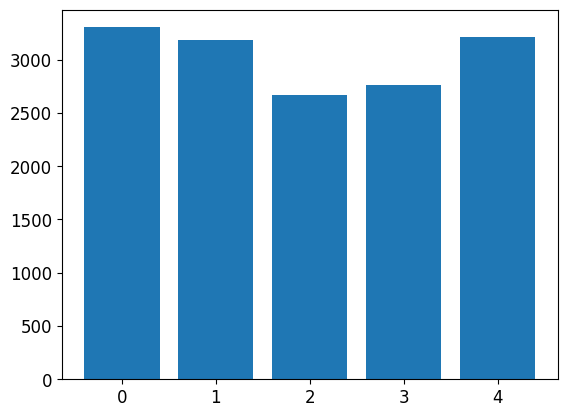

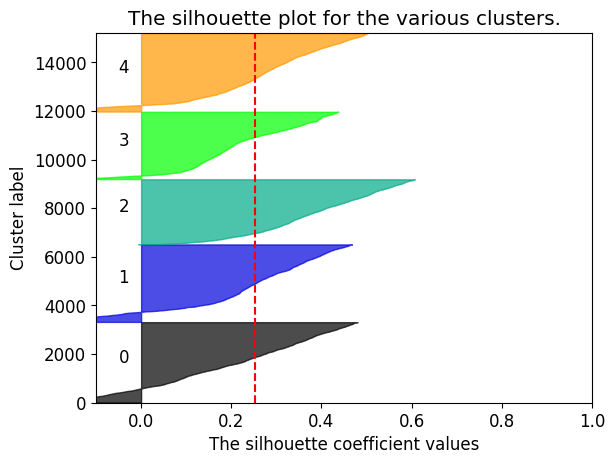

Number of clusters = 6
Number of cluster points = 15141
Number of noisy points = 0


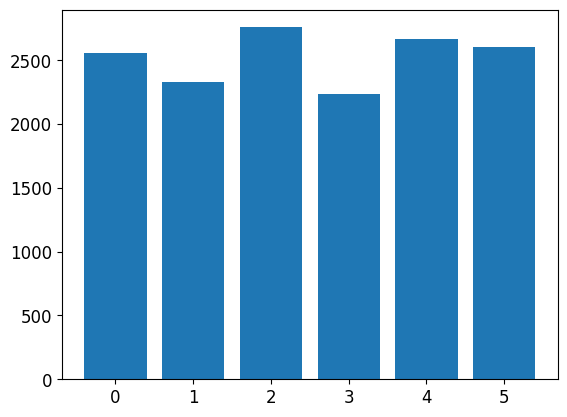

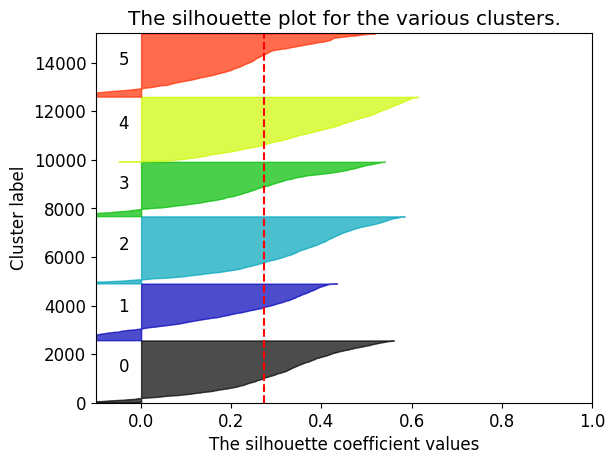

Number of clusters = 7
Number of cluster points = 15141
Number of noisy points = 0


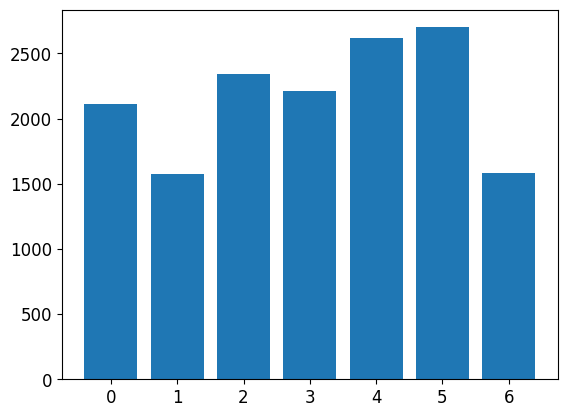

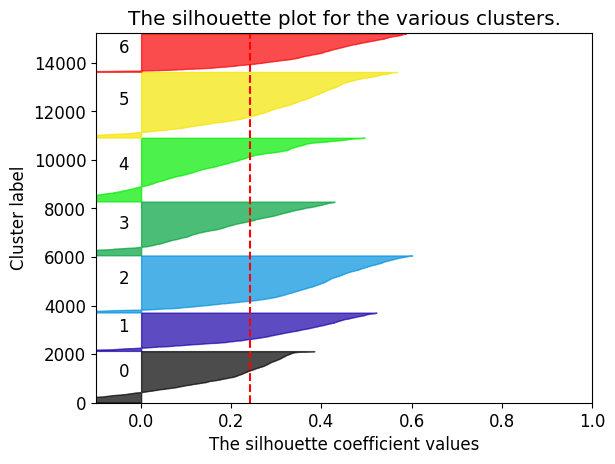

Number of clusters = 8
Number of cluster points = 15141
Number of noisy points = 0


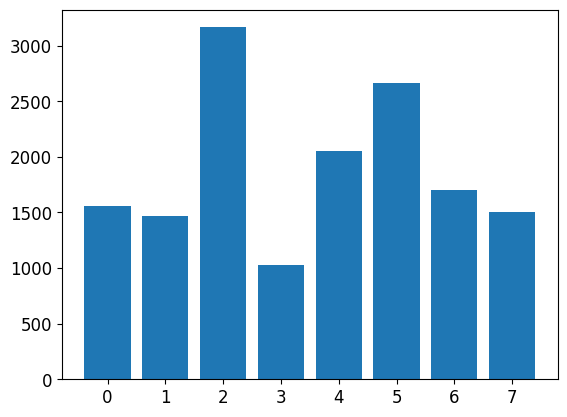

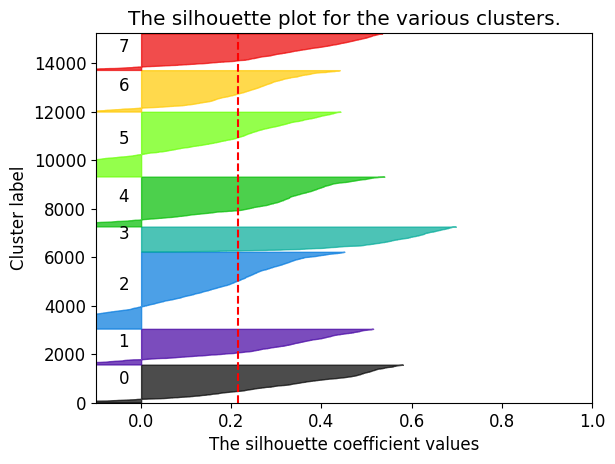

Number of clusters = 9
Number of cluster points = 15141
Number of noisy points = 0


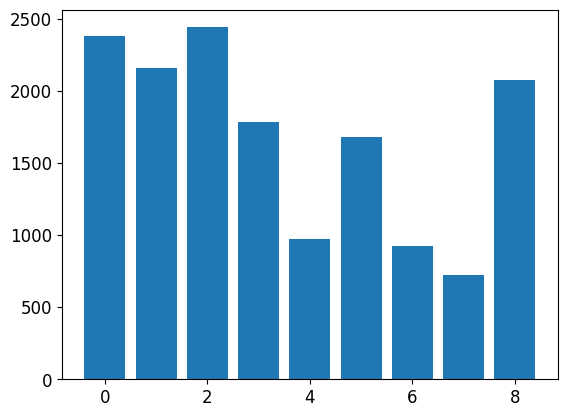

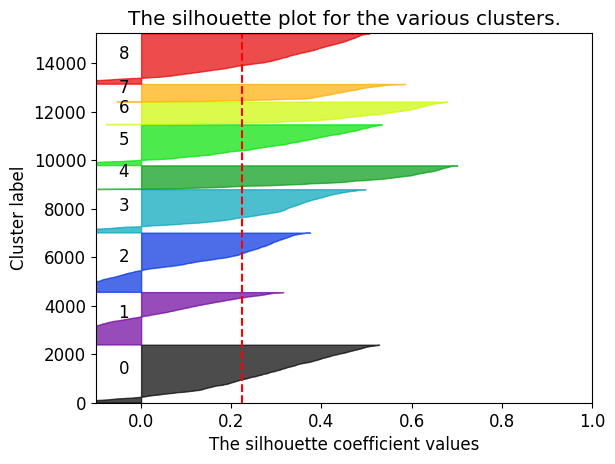

In [24]:
from sklearn.mixture import GaussianMixture

X = StandardScaler().fit_transform(tsne_embedding)
for i in range(2,10):
    db = GaussianMixture(n_components=i, covariance_type='full').fit(X)
    #core_samples_mask = np.zeros_like(labels, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.predict(X)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    noisy_points = labels==-1
    cluster_points = ~noisy_points
    print("Number of clusters = %d"%n_clusters_)
    print("Number of cluster points = %d"%sum(cluster_points))
    print("Number of noisy points = %d"%sum(noisy_points))
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique,counts)
    plt.show()
    compute_silhuette(X,labels)

[126258.27011458123, 124231.14204919466, 122356.40766872418, 121332.3816186406, 117520.48562415148, 115660.47899747608, 113073.16845040373, 110228.74404198855, 109719.18020777208, 107138.83014365316, 106372.49618227877, 104015.42334224915, 104339.7328874733, 98291.73725650125, 99587.54135620662, 94731.35475430677, 93823.07457797132, 89611.42697695836, 92396.91461008438, 89349.71566052237, 87255.82679550315, 83336.81830858205, 82573.32767229277, 81304.92339518068, 80326.15231735804, 79763.16361688061, 78650.53895067792, 77085.84834212517, 76675.50501537218, 76621.39559624236, 75153.87432881146, 75063.58846610942, 74269.13549473931, 75548.65277532415, 73676.54922541627, 73542.95416627833, 71096.80792523178, 72607.00631159748, 71094.6548251826, 71237.43424219589, 69354.99070143086, 68613.10022425446, 68025.37206759863, 68512.38453138806, 68810.46433736263, 69080.10068857872, 67050.77955784956, 66781.85580286007, 66452.0214391385, 68208.1243264067, 65541.07995188399, 66140.74449513917, 646

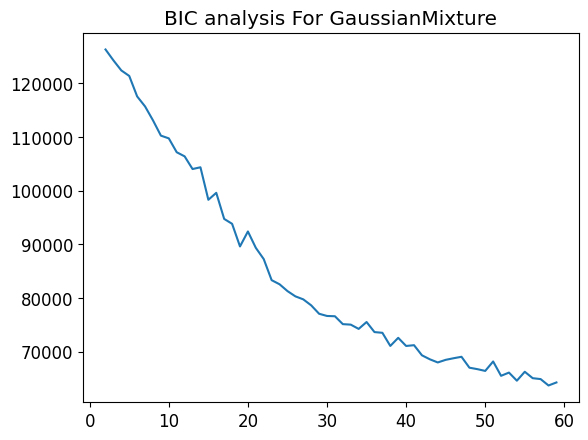

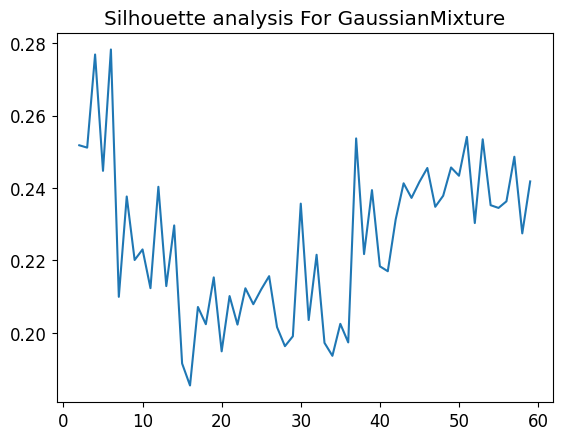

In [22]:
def KneeElbowAnalysis_Gaussian(X,max_k=20):
    k_values = range(2,max_k)
    clusterings = [GaussianMixture(n_components=k, covariance_type='full').fit(X) for k in k_values]
    bics = [cl.bic(X) for cl in clusterings]
    silhouette = [silhouette_score(X, cl.predict(X), metric='euclidean') for cl in clusterings]
    plt.plot(k_values,bics)
    plt.title("BIC analysis For GaussianMixture")
    plt.show()
    plt.plot(k_values,silhouette)
    plt.title("Silhouette analysis For GaussianMixture")
    plt.show()

KneeElbowAnalysis_Gaussian(X,60)

# KMeans

In [15]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

def KneeElbowAnalysisKMEANS(x,max_k=20):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=1234, n_init='auto').fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.xticks(k_values)
    plt.plot(k_values, wcss, 'o-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'o-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');


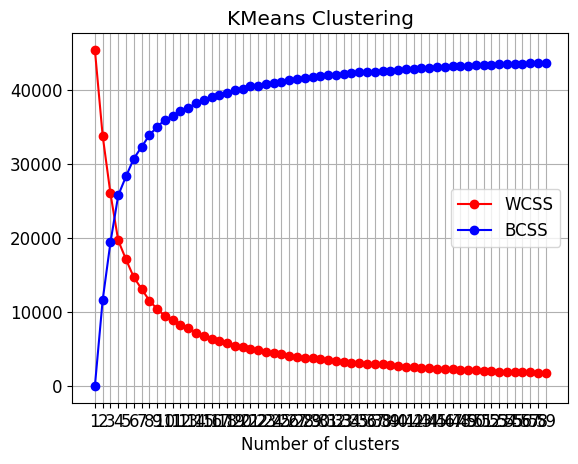

In [17]:
X = StandardScaler().fit_transform(tsne_embedding)
KneeElbowAnalysisKMEANS(X,60)